In [43]:
from zipfile import ZipFile
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix, roc_curve,auc

In [25]:
tf.random.set_seed(42)
np.random.seed(42)

train_dir = r"C:\Users\bhanu\Downloads\archive (3)\train"
test_dir = r"C:\Users\bhanu\Downloads\archive (3)\test"

In [26]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'  
)
print("apples=0, tomatoes=1")
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)



Found 249 images belonging to 2 classes.
apples=0, tomatoes=1
Found 97 images belonging to 2 classes.


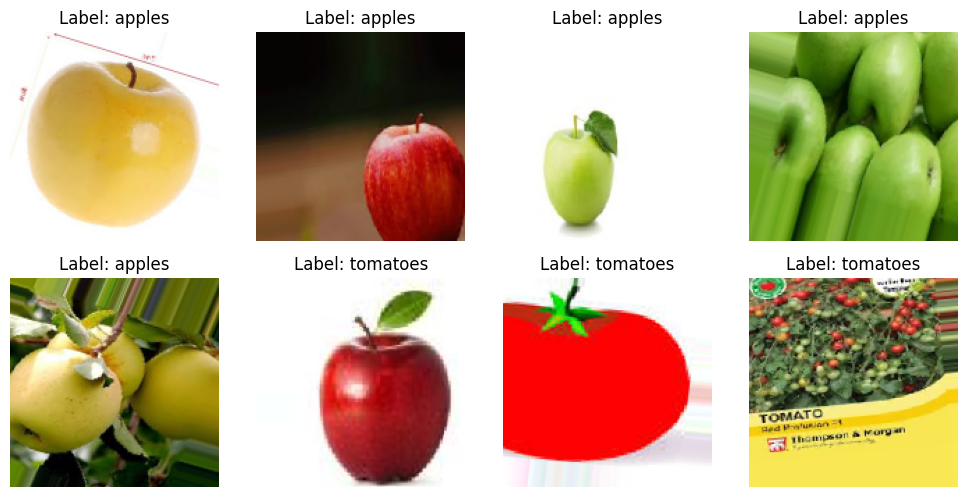

In [27]:
def plot_sample_images(generator, num_samples=8):
    images, labels = next(generator)
    class_names = list(generator.class_indices.keys())
    
    plt.figure(figsize=(10, 10))
    for i in range(num_samples):
        plt.subplot(4, 4, i+1)
        plt.imshow(images[i])
        plt.title(f"Label: {class_names[int(labels[i])]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_sample_images(train_generator)

In [37]:
def create_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
        MaxPooling2D(2, 2),
        
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        
        Conv2D(256, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        
        Flatten(),
        Dropout(0.5),
        Dense(512, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )
    
    return model

model = create_model()
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)                   │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 15, 15, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 7, 7, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 512)                 │       6,423,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,811,969 (25.99 MB)

 Trainable params: 6,811,969 (25.99 MB)

 Non-trainable params: 0 (0.00 B)

In [38]:

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=30,
    validation_data=test_generator,
    validation_steps=test_generator.samples // test_generator.batch_size,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 528ms/step - accuracy: 0.6227 - auc: 0.4943 - loss: 0.6626 - val_accuracy: 0.5625 - val_auc: 0.6005 - val_loss: 0.7091
Epoch 2/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.6250 - auc: 0.6021 - loss: 0.6619 - val_accuracy: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 1.1158
Epoch 3/30


C:\Users\bhanu\AppData\Local\Programs\Python\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 431ms/step - accuracy: 0.6589 - auc: 0.6600 - loss: 0.6219 - val_accuracy: 0.5625 - val_auc: 0.6261 - val_loss: 0.6853
Epoch 4/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5938 - auc: 0.7814 - loss: 0.6297 - val_accuracy: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.9689
Epoch 5/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 437ms/step - accuracy: 0.6702 - auc: 0.6591 - loss: 0.6088 - val_accuracy: 0.5833 - val_auc: 0.6208 - val_loss: 0.6669
Epoch 6/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7812 - auc: 0.7474 - loss: 0.5673 - val_accuracy: 1.0000 - val_auc: 0.0000e+00 - val_loss: 0.6808
Epoch 7/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 437ms/step - accuracy: 0.7342 - auc: 0.7088 - loss: 0.5982 - val_accuracy: 0.5729 - val_auc: 0.6250 - val_loss: 0.6783
Epoch 8/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.6875 - auc: 0.7338 - loss: 0.5718 - val_accuracy: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.8014
Epoch 9/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 439ms/s

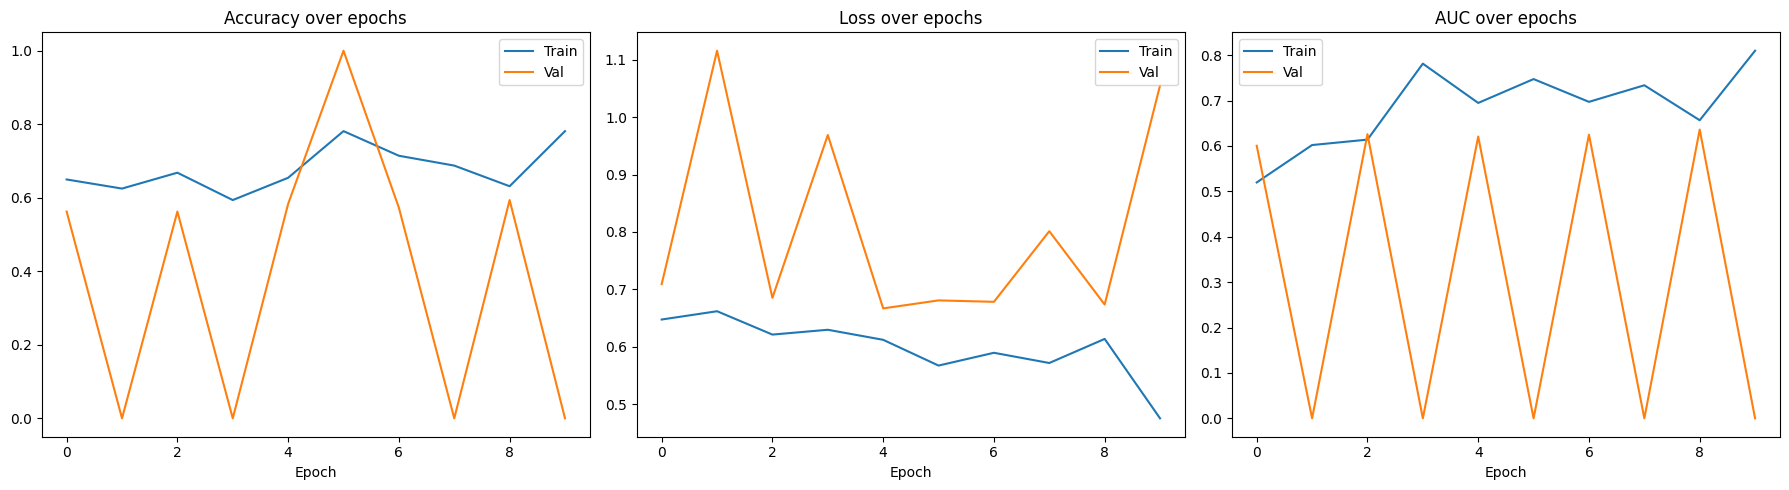

In [40]:
def plot_history(hist):
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    metrics = ['accuracy', 'loss', 'auc']
    titles = ['Accuracy', 'Loss', 'AUC']
    for i, metric in enumerate(metrics):
        axes[i].plot(hist.history[metric], label='Train')
        axes[i].plot(hist.history[f'val_{metric}'], label='Val')
        axes[i].set_title(f'{titles[i]} over epochs')
        axes[i].set_xlabel('Epoch')
        axes[i].legend()
    plt.tight_layout()
    plt.show()

plot_history(history)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - accuracy: 0.6236 - auc: 0.5234 - loss: 0.6476 

Test Accuracy: 0.5876
Test AUC: 0.6240
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/stepWARNING:tensorflow:5 out of the last 25 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000001C51390F9C0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step

Classification Report:
              precision    recall  f1-score  

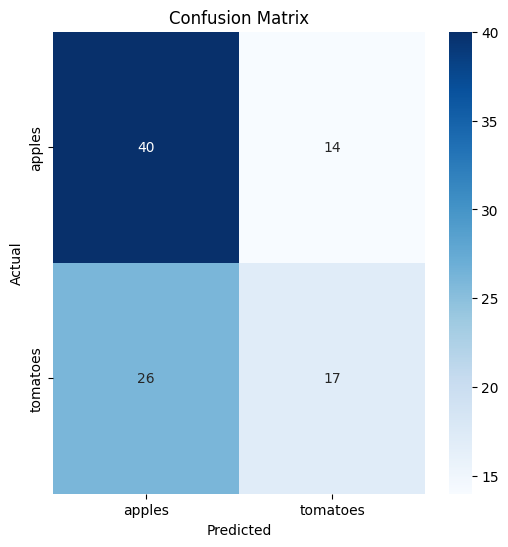

In [41]:
test_loss, test_acc, test_auc = model.evaluate(test_generator)
print(f"\nTest Accuracy: {test_acc:.4f}")
print(f"Test AUC: {test_auc:.4f}")

# Generate predictions
y_pred = model.predict(test_generator)
y_pred_classes = (y_pred > 0.5).astype(int)
y_true = test_generator.classes

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=['apples', 'tomatoes']))

# Confusion matrix
plot_confusion_matrix(y_true, y_pred_classes)

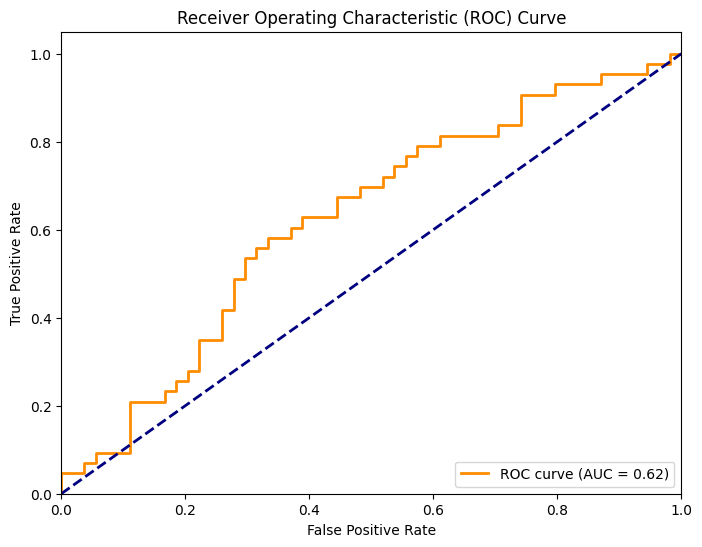

In [42]:

plot_roc_curve(y_true, y_pred)
